# Load Libs

In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf
import seaborn as sns, keras
sns.set(style='white')

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

from sklearn.metrics import roc_curve, auc
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, BatchNormalization, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import Concatenate
from keras.optimizers import Adam, SGD
from keras import regularizers

np.set_printoptions(precision=4, suppress=True, linewidth=100)

Using TensorFlow backend.


# Data Preview

In [2]:
ratings = pd.read_csv('https://storage.googleapis.com/allianz-course/data/ratings.csv')
movies = pd.read_csv('https://storage.googleapis.com/allianz-course/data/movies.csv')

In [3]:
print(movies.shape)
movies.head()

(9125, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
print(ratings.rating.describe(), '\n')
print(ratings.rating.value_counts())

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64 

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64


## Observations
* rating的分數介於 0.5 ~ 5分, 最小差距為0.5

# Encode

In [6]:
# Fit user id and movie id
uid_enc, mid_enc = LabelEncoder(), LabelEncoder()
uid_enc.fit(ratings.userId)
mid_enc.fit(movies.movieId)

# Encode user id and movie id to indexed real value
ratings["userId"] = uid_enc.transform(ratings.userId)
ratings["movieId"] = mid_enc.transform(ratings.movieId)
movies["movieId"] = mid_enc.transform(movies.movieId)

# Dictionary of movie id and title
mid_map = pd.Series(dict(zip(movies.movieId, movies.title)))

# Number of users, number of movies
n_users, n_movies = len(uid_enc.classes_), len(mid_enc.classes_)

# Split Train, Test Data
* 以4分為閥值, 4分以上為positive, 未滿4分為negative
* 每個user分positive, negative兩部分, 各取30%到valid data

In [7]:
def split_ratings(data, pos_thres=4, test_ratio=0.3):
    """依照test_ratio切割movielens train test資料"""
    tr, te = [], []
    for u, df in data.groupby("userId"):
        if len(df) < 5: continue

        pos, neg = df.query("rating >= {}".format(pos_thres)), df.query("rating < {}".format(pos_thres))
        # Split positive part
        pos_len = int(len(pos) * (1 - test_ratio))
        tr_pos = pos[:pos_len]
        te_pos = pos[pos_len:]
        # Split negative part
        neg_len = int(len(neg) * (1 - test_ratio))
        tr_neg = neg[:neg_len]
        te_neg = neg[neg_len:]

        tr.append(tr_pos.append(tr_neg))
        te.append(te_pos.append(te_neg))
    return pd.concat(tr, ignore_index=True), pd.concat(te, ignore_index=True)

tr, te = split_ratings(ratings, 4, .3)

# Make Rating Matrix (Interaction Between Users and Movies)

In [8]:
tr_rating_mat = np.zeros((n_users, n_movies))
# Valid data rating matrix
te_rating_mat = np.zeros((n_users, n_movies))

# Train rating matrix
for idx, r in tr.iterrows():
    tr_rating_mat[int(r.userId), int(r.movieId)] = r.rating
# Valid rating matrix    
for idx, r in te.iterrows():
    te_rating_mat[int(r.userId), int(r.movieId)] = r.rating
    
print('Shape of train interaction matrix: ', tr_rating_mat.shape)
print(tr_rating_mat, '\n')
print('Shape of test interaction matrix: ', te_rating_mat.shape)
print(te_rating_mat)

Shape of train interaction matrix:  (671, 9125)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]] 

Shape of test interaction matrix:  (671, 9125)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Transformed Data

In [9]:
print( tr.head() )
print()
print( te.head() )

   userId  movieId  rating   timestamp
0       0      931     4.0  1260759205
1       0     1515     4.0  1260759191
2       0       30     2.5  1260759144
3       0      833     3.0  1260759179
4       0      859     3.0  1260759182

   userId  movieId  rating   timestamp
0       0     1665     4.0  1260759139
1       0     1708     3.0  1260759194
2       0     1743     2.0  1260759198
3       0     1815     2.0  1260759108
4       0     1962     2.5  1260759113


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

# Model of Matrix Factorization

In [10]:
from keras.layers import dot, add, Layer
from keras import regularizers
from keras.optimizers import Adagrad, SGD, Adam
from keras.callbacks import ModelCheckpoint

## Build model function

In [11]:
def get_model(n_users, n_movies, emb_size, reg):
    # Input tesors
    inp_user = Input([1], dtype='int32')
    inp_movie = Input([1], dtype='int32')
    # Hack: only input integer => "0"
    inp_global = Input([1], dtype='int32')
    
    # User, movie embedding
    emb_user = Embedding(n_users, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_user')(inp_user)
    emb_movie = Embedding(n_movies, emb_size, embeddings_initializer='glorot_uniform',
                         embeddings_regularizer=regularizers.l2(reg), name='emb_movie')(inp_movie)
    emb_user = Flatten()(emb_user)
    emb_movie = Flatten()(emb_movie)
    
    # Bias terms
    b_user = Flatten()(Embedding(n_users, 1, 
                                 embeddings_initializer='glorot_uniform', 
                                 name='b_user')(inp_user))
    b_movie = Flatten()(Embedding(n_movies, 1, 
                                  embeddings_initializer='glorot_uniform', 
                                  name='b_movie')(inp_movie))
    b_global = Flatten()(Embedding(1, 1, 
                                   embeddings_initializer='glorot_uniform', 
                                   name='b_global')(inp_global))
    # Implements the formulation
    nets = dot([emb_user, emb_movie], axes=1)
    nets = add([nets, b_user, b_movie, b_global])
    
    # Input: [user, movie, zero]
    model = Model([inp_user, inp_movie, inp_global], nets)
    model.summary()
    return model, Model(inp_movie, emb_movie)

emb_size = 16
reg = 0.0005
batch_size = 128
epochs = 20

K.clear_session()
model_mf, _ = get_model(n_users, n_movies, emb_size, reg)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
emb_user (Embedding)            (None, 1, 16)        10736       input_1[0][0]                    
__________________________________________________________________________________________________
emb_movie (Embedding)           (None, 1, 16)        146000      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (I

# Training

In [12]:
tr_x = [tr.userId[:, None], 
        tr.movieId[:, None], 
        np.zeros([len(tr), 1])]
tr_y = tr.rating[:, None]
# -----------------------------------------------------------------------
te_x = [te.userId[:, None], 
        te.movieId[:, None], 
        np.zeros([len(te), 1])]
te_y = te.rating[:, None]

## Use Callback Function
* keras.callbacks.ModelCheckpoint: 只存檔最好的結果, 是另一種防止overfitting的方式
    * save_best_only = True

Train on 69399 samples, validate on 30605 samples
Epoch 1/20
69399/69399 [==============================] - 3s 47us/step - loss: 1.8022 - val_loss: 1.0776
Epoch 2/20
69399/69399 [==============================] - 2s 28us/step - loss: 0.8533 - val_loss: 0.9301
Epoch 3/20
69399/69399 [==============================] - 2s 28us/step - loss: 0.7767 - val_loss: 0.8968
Epoch 4/20
69399/69399 [==============================] - 2s 28us/step - loss: 0.7463 - val_loss: 0.8854
Epoch 5/20
69399/69399 [==============================] - 2s 28us/step - loss: 0.7292 - val_loss: 0.8788
Epoch 6/20
69399/69399 [==============================] - 2s 28us/step - loss: 0.7178 - val_loss: 0.8737
Epoch 7/20
69399/69399 [==============================] - 2s 29us/step - loss: 0.7095 - val_loss: 0.8726
Epoch 8/20
69399/69399 [==============================] - 2s 28us/step - loss: 0.7031 - val_loss: 0.8710
Epoch 9/20
69399/69399 [==============================] - 2s 28us/step - loss: 0.6981 - val_loss: 0.8724
Epoch

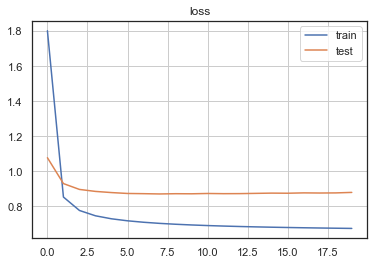

In [13]:
model_mf.compile(optimizer=Adagrad(lr=0.1), loss='mse')

model_dir = "./model_mf"
hist = model_mf.fit(x=tr_x,
                    y=tr_y,
                    validation_data=(te_x, te_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[ModelCheckpoint(filepath=model_dir, 
                                               save_weights_only=True, 
                                               save_best_only=True)])

# After training, load the best weights back
model_mf.load_weights(model_dir)

sns.lineplot(np.arange(len(hist.history['loss'])), hist.history['loss'], label='train')
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'], label='test')
plt.title('loss')
plt.grid(True)
plt.show()

# Prediction

In [14]:
pred = model_mf.predict(te_x).ravel()
print('Shape of test data: ', pred.shape)

Shape of test data:  (30605,)


# Metrics
* 定義4分以上為正向評價, 4分以下為負向評價

## RMSE 

In [15]:
print("RMSE: ", np.sqrt(np.mean((pred - te_y.ravel())**2)))

RMSE:  0.9329331680619126


## AUC

auc: 0.7467134204166853


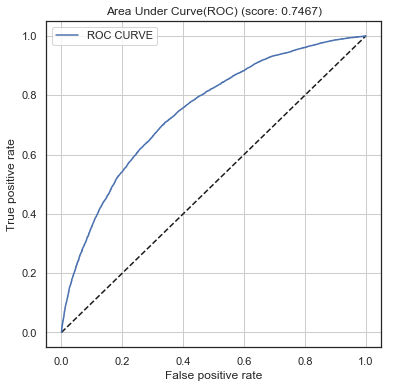

In [16]:
def draw_roc_curve(y, pred_proba):
    fpr, tpr, _ = roc_curve(y, pred_proba, pos_label=1)
    auc_scr = auc(fpr, tpr)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.grid(True)
    plt.show()
    
draw_roc_curve(te.rating >= 4, pred / pred.max())

## Single User Rating Histogram

In [ ]:
# user id from 0 ~ 670
uid = 22
tmp = te.query(f"userId == {uid}")
single_pred = model_mf.predict(
    [np.repeat(uid, len(tmp.movieId))[:, None],
     tmp.movieId[:, None],
     np.zeros([len(tmp.movieId), 1])]).ravel()

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribute")
sns.distplot(single_pred, ax=ax[0])
ax[1].set_title("real distribute")
sns.distplot(te.query(f"userId == '{uid}'").rating, ax=ax[1])
plt.show()

## Single User Detail Table

In [ ]:
# user id from 0 ~ 670
uid = 22
tmp = te.query(f"userId == {uid}")
single_pred = model_mf.predict(
    [np.repeat(uid, len(tmp.movieId))[:, None],
     tmp.movieId[:, None],
     np.zeros([len(tmp.movieId), 1])]).ravel()

recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": tmp.movieId,
              "title": mid_map[tmp.movieId].values,
              "rating": tmp.rating.values,
              "predRating": single_pred},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.sort_values("rating", ascending=False)

In [ ]:
recommDf.sort_values("predRating", ascending=False)

## Precision@K (K = 10)

### Before Computing Precision@K, See the Count Plot Below First

In [ ]:
pos_ary, neg_ary = [], []
for label in te_rating_mat:
    label = label[label != 0]
    pos_ary.append(sum(label >= 4))
    neg_ary.append(sum(label < 4))
    
def draw_pos_neg(idx):
    pd.DataFrame(
        index=idx,
        data={"pos": np.array(pos_ary)[idx], "neg": np.array(neg_ary)[idx]}).plot.bar(figsize=(10, 5), alpha=0.8)
    plt.grid(True)
    plt.show()

draw_pos_neg(np.arange(len(te_rating_mat))[0:10])

### Observations
1. 0號, 2號, 5號, 9號 user 正向評價數量 < 10, 就算model全部預測命中, 命中率也不會是 100%!
    ex: 0號user只有1個正向評價, 全部命中也只得到0.1的分數
2. 3號user正向評價是負向評價的5倍多, 就算亂猜, 中的機率也很高

In [ ]:
def strict_condition(label):
    label = label[label != 0]
    pos, neg = sum(label >= 4), sum(label < 4)
    return len(label) >= 10 and pos <= neg and pos > 0

def norm_condition(label):
    label = label[label != 0]
    return sum(label >= 4) > 0 and sum(label < 4) > 0

_ = sum(np.sum(te_rating_mat >= 4, 1) < 10)
print("{} 個user正向評價總數小於10!".format(_))
print("rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [{}] 人".format(sum(strict_condition(label) for label in te_rating_mat)))
print("rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [{}] 人".format(sum(norm_condition(label) for label in te_rating_mat)))

In [ ]:
def precision_at_k(truth, pred_mat, condition_fn=None, k=10, label_thres=4):
    hits, total = 0, 0
    for label, pr in zip(truth, pred_mat):
        if not condition_fn(label): continue

        top_k_ind = (pr * (label != 0)).argsort()[::-1][:k]
        hits += sum(label[top_k_ind] >= label_thres)
        total += k
    return hits / total

In [ ]:
pred_mat = np.zeros_like(te_rating_mat)
pred_mat[te.userId, te.movieId] = pred
    
print( "strict condition precision at 10: ", precision_at_k(te_rating_mat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(te_rating_mat, pred_mat, norm_condition, k=10) )

## NDCG: Normalized Discounted Cumulative Gain
1. A measure of ranking quality.
2. loop 每一位user, prediciton score排序後計算NDCG
    <br/>$$ DCG_p = \sum^p_{i = 1} \frac{2^{rel_i} - 1}{log_2(i + 1)} $$<br/>
3. IDCG: Ideal DCG, 為理想狀態下的DCG分數, 即model全部命中的DCG分數, 而NDCG: Normalized DCG, 公式如下
    <br/>$$ NDCG_p = \sum^p_{i = 1} \frac{DCG_p}{IDCG_p} $$<br/>
4. 所以NDCG是一個比值, 介於0 ~ 1之間

In [ ]:
def all_user_ndcg(label_mat, pred_mat, cond_fn, label_thres=4, k=10):
    """avg of all user ndcg score"""
    tot_ndcg, actual_cnt = 0, 0
    for i, (label, score) in enumerate(zip(label_mat, pred_mat)):
        if not cond_fn(label): continue

        ndcg = single_user_ndcg(label, score, k=10)
        if ndcg is not None:
            tot_ndcg += ndcg
            actual_cnt += 1
    return tot_ndcg / actual_cnt

def single_user_ndcg(label, score, label_thres=4, k=10):
    """single user ndcg score"""
    nnz = label.nonzero()[0]
    # if np.sum(label >= label_thres) < k: return None
    label, score = label[nnz], score[nnz]
    label = (label >= label_thres).astype(int)
    return ndcg_score(label, score, k)

def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    """Normalized discounted cumulative gain (NDCG) at rank k"""
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual / best

def dcg_score(y_true, y_score, k=10, gains="exponential"):
    """Discounted cumulative gain (DCG) at rank k"""
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)

In [ ]:
pred_mat = np.zeros_like(te_rating_mat)
pred_mat[te.userId, te.movieId] = pred
    
strict_ndcg = all_user_ndcg(te_rating_mat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(te_rating_mat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

<br/>
<br/>
<br/>
<br/>
<br/>

## Baseline: 不經過訓練隨機產生預測值

### ROC

In [ ]:
dummyPredMat = np.random.random((n_users, n_movies))
draw_roc_curve((te_rating_mat >= 4).astype(int).ravel(), dummyPredMat.ravel())

### 不經過訓練隨機產生預測值 RMSE

In [ ]:
mask = te_rating_mat > 0
print("rmse of dummy model(valid data): ", np.sqrt(np.mean( (te_rating_mat[mask] - dummyPredMat[mask])**2)) )

### 不經過訓練隨機產生預測值 precision at 10

In [ ]:
print( "strict condition precision at 10: ", precision_at_k(te_rating_mat, dummyPredMat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(te_rating_mat, dummyPredMat, norm_condition, k=10) )

### 不經過訓練隨機產生預測值 ndcg at 10

In [ ]:
strict_ndcg = all_user_ndcg(te_rating_mat, dummyPredMat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(te_rating_mat, dummyPredMat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)